# SHOR'S ALGORITHM

- Involves a classical + quantum sub-routine part
- the quantum part comes from computing the period for the function $$f(x) = a^x mod N$$
- The period $$r => a^r == 1 mod N$$

## ALGORITHM

For a number N: (N assumed to be odd and not a perfect power aka N!= s^j)
- Pick a random number $1<a<N$ s.t it is co-prime with N (checked by gcd = 1)
- find the period r for the above function
- if r is odd or $a^{r/2} == -1 mod N $ , repeat steps from start (failure, probability of this occuring is atmost 0.5 , running algorithm multiple times will push error happening on every run of the algorithm down to atmost (0.5)^(run time))
- else : $a^r - 1 = 0 mod N => (a^{r/2} - 1)(a^{r/2} + 1) = 0 mod N$
- both numbers are multiples of N , computing one of $gcd(a^{r/2}+-1,N)$ gives us one of the 2 prime factors required. ( can get other by dividing by N)

## QUANTUM PERIOD FINDING
- it is simply the QPE for the $U|y> = |ya (mod N)>$
- This is applied to input state $|y=1>$ , which is an equal superposition of all eigenvalues $exp(2\pi{i}s/r) , s = 0..r-1
- Measured output

# CIRCUIT CONSTRAINTS
- in total , we need t + floor(log(N)) qubits
- Here , t is a hyper parameter which is defined as : for an accuracy upto n bits of the phase estimated , with $$P(success)>= (1-\epsilon)$$
  $$t = n + ciel(log(2+1/2\epsilon))$$
- however , in this implementation , we choose t : $$N^2<= 2^t <=N^{2+1}$$

In [ ]:
pip install qiskit

In [ ]:
# pylint: disable=invalid-name
import matplotlib.pyplot as plt
import numpy as np
from qiskit import *
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram, plot_state_city
import qiskit.quantum_info as qi
from qiskit.visualization import plot_histogram
from math import gcd
from numpy.random import randint
import pandas as pd
from fractions import Fraction
print("Imports Successful")

# CIRCUIT : FACTORING OF N=15

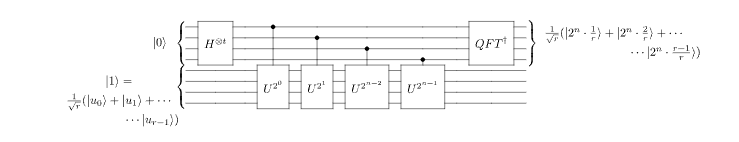

In [3]:
def c_amod15(a,power): # a represents the co-prime number to N(=15) 
    if a not in [2,4,7,8,11,13]:
        print("a isnt co prime to 15")
    U = QuantumCircuit(4) #bottom log(15) qubits
    # performing U operations based of input = a ( v specific to N = 15 's case here )
    for it in range(power):
        if a in [2,13]:
            U.swap(2,3)
            U.swap(1,2)
            U.swap(0,1)
        if a in [7,8]:
            U.swap(0,1)
            U.swap(1,2)
            U.swap(2,3)
        if a in [4, 11]:
            U.swap(1,3)
            U.swap(0,2)
            
        if a in [7,11,13]:
            for q in range(4):
                U.x(q)
    # conv U to a gate on 4 qubits
    U = U.to_gate()
    U.name = f"{a}^{power} mod 15"
    c_U = U.control() # making a control version of the gate
    return c_U


In [4]:
# we use t = 8 here
t = 8
a = 2 # can be chosen as smth else too

### QFT operation/ckt

In [5]:
def qft_dagger(n): # n-qubit QFT inv operation
    qc = QuantumCircuit(n)
    # creating the ciruit using swaps and controlled phase gates
    for qubit in range(n//2):
        qc.swap(qubit, n-qubit-1)
    for j in range(n):
        for m in range(j):
            qc.cp(-np.pi/float(2**(j-m)), m, j)
        qc.h(j)
    QFT_inv = qc.to_gate()
    QFT_inv.name = "QFT†"
    return QFT_inv

### writing shor's algorithm

In [6]:
qc = QuantumCircuit(t + 4 , t) # log(15) = 4 and need t classical bits to store the info
# superimposing all initial t qbits
for q in range(t):
    qc.h(q)
# rest 4 combined in state |00001>
qc.x(t)
# doing controlled-U operations
# here , the 1st bit supplied (q) is the control bit for the c_U operation returned
# by the function
for q in range(t):
    qc.append(c_amod15(a,2**q),[q] + [t,t+1,t+2,t+3])

# applying Qft_inv
qc.append(qft_dagger(t),range(t))

# measure ckt - t qubits measure , store in t classical ones
qc.measure(range(t),range(t))
qc.draw(fold = -1) # draw ckt (fold = 1 makes it more like vertical)

┌───┐                                                                                                                             ┌───────┐┌─┐                     
 q_0: ┤ H ├───────■─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤0      ├┤M├─────────────────────
      ├───┤       │                                                                                                                     │       │└╥┘┌─┐                  
 q_1: ┤ H ├───────┼──────────────■──────────────────────────────────────────────────────────────────────────────────────────────────────┤1      ├─╫─┤M├──────────────────
      ├───┤       │              │                                                                                                      │       │ ║ └╥┘┌─┐               
 q_2: ┤ H ├───────┼──────────────┼──────────────■───────────────────────────────────────────────────────────────────────────────────────┤2      ├─╫──╫─┤M├───────────────
      ├───┤       │              │              │                                                                                       │       │ ║  ║ └╥┘┌─┐            
 q_3: ┤ H ├───────┼──────────────┼──────────────┼──────────────■────────────────────────────────────────────────────────────────────────┤3      ├─╫──╫──╫─┤M├────────────
      ├───┤       │              │              │              │                                                                        │  QFT† │ ║  ║  ║ └╥┘┌─┐         
 q_4: ┤ H ├───────┼──────────────┼──────────────┼──────────────┼──────────────■─────────────────────────────────────────────────────────┤4      ├─╫──╫──╫──╫─┤M├─────────
      ├───┤       │              │              │              │              │                                                         │       │ ║  ║  ║  ║ └╥┘┌─┐      
 q_5: ┤ H ├───────┼──────────────┼──────────────┼──────────────┼──────────────┼───────────────■─────────────────────────────────────────┤5      ├─╫──╫──╫──╫──╫─┤M├──────
      ├───┤       │              │              │              │              │               │                                         │       │ ║  ║  ║  ║  ║ └╥┘┌─┐   
 q_6: ┤ H ├───────┼──────────────┼──────────────┼──────────────┼──────────────┼───────────────┼───────────────■─────────────────────────┤6      ├─╫──╫──╫──╫──╫──╫─┤M├───
      ├───┤       │              │              │              │              │               │               │                         │       │ ║  ║  ║  ║  ║  ║ └╥┘┌─┐
 q_7: ┤ H ├───────┼──────────────┼──────────────┼──────────────┼──────────────┼───────────────┼───────────────┼────────────────■────────┤7      ├─╫──╫──╫──╫──╫──╫──╫─┤M├
      ├───┤┌──────┴──────┐┌──────┴──────┐┌──────┴──────┐┌──────┴──────┐┌──────┴───────┐┌──────┴───────┐┌──────┴───────┐┌───────┴───────┐└───────┘ ║  ║  ║  ║  ║  ║  ║ └╥┘
 q_8: ┤ X ├┤0            ├┤0            ├┤0            ├┤0            ├┤0             ├┤0             ├┤0             ├┤0              ├──────────╫──╫──╫──╫──╫──╫──╫──╫─
      └───┘│             ││             ││             ││             ││              ││              ││              ││               │          ║  ║  ║  ║  ║  ║  ║  ║ 
 q_9: ─────┤1            ├┤1            ├┤1            ├┤1            ├┤1             ├┤1             ├┤1             ├┤1              ├──────────╫──╫──╫──╫──╫──╫──╫──╫─
           │  2^1 mod 15 ││  2^2 mod 15 ││  2^4 mod 15 ││  2^8 mod 15 ││  2^16 mod 15 ││  2^32 mod 15 ││  2^64 mod 15 ││  2^128 mod 15 │          ║  ║  ║  ║  ║  ║  ║  ║ 
q_10: ─────┤2            ├┤2            ├┤2            ├┤2            ├┤2             ├┤2             ├┤2             ├┤2              ├──────────╫──╫──╫──╫──╫──╫──╫──╫─
           │             ││             ││             ││             ││              ││              ││              ││               │          ║  ║  ║  ║  ║  ║  ║  ║ 
q_11: ─────┤3            ├┤3            ├┤3            ├┤3            ├┤3             ├┤3       

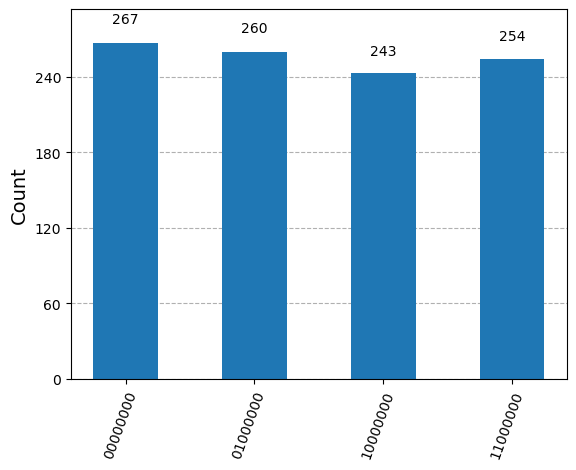

In [7]:
aer_sim = AerSimulator()
t_qc = transpile(qc, aer_sim)
counts = aer_sim.run(t_qc).result().get_counts()
plot_histogram(counts)

In [8]:
# this output is essentially (s/r)/2*t (t = 2n) - s is the random eigenvector number we got
# as our input is |1> = sum of all eigenstates from s = 0 to r-1
#converting to s/r
rows, measured_phases = [], []
for output in counts:
    decimal = int(output, 2)  # Convert (base 2) string to decimal
    phase = decimal/(2**t)  # Find corresponding eigenvalue
    measured_phases.append(phase)
    # Add these values to the rows in our table:
    rows.append([f"{output}(bin) = {decimal:>3}(dec)",
                 f"{decimal}/{2**t} = {phase:.2f}"])
# Print the rows in a table
headers=["Register Output", "Phase"]
df = pd.DataFrame(rows, columns=headers)
print(df)

            Register Output           Phase
0  11000000(bin) = 192(dec)  192/256 = 0.75
1  01000000(bin) =  64(dec)   64/256 = 0.25
2  10000000(bin) = 128(dec)  128/256 = 0.50
3  00000000(bin) =   0(dec)    0/256 = 0.00


In [9]:
# continued fractions to determine r
rows = []
for phase in measured_phases:
    frac = Fraction(phase).limit_denominator(15) #gets the c.f expansion
    rows.append([phase,
                 f"{frac.numerator}/{frac.denominator}",
                 frac.denominator])
#print
headers=["Phase", "Fraction", "Guess for r"]
df = pd.DataFrame(rows,columns = headers)
print(df)

   Phase Fraction  Guess for r
0   0.75      3/4            4
1   0.25      1/4            4
2   0.50      1/2            2
3   0.00      0/1            1


Now we use this r to get N's factors
$$a^r mod N = 1$$ (must be checked as algo has chance of failing)
$$(a^r - 1) mod N = 0$$
$$=> (a^{r/2} - 1)(a^{r/2} + 1) = 0 {mod N} $$
thus , our factors are one of $$gcd(a^{r/2} - 1,N) , gcd(a^{r/2} + 1,N)$$

In [10]:
N = 15
for entry in rows:
    r = entry[2] #our guess
    if r%2!=0:
        continue # failed guess
    factor_guess = gcd(N,a^(int(r/2))-1)
    if factor_guess in [1,15]: # choosing other one
        factor_guess = gcd(N,a^(int(r/2)+1))
    print(factor_guess,int(N/factor_guess))
# we get 3 different r's which result in the non trivial factors 3 and 5

3 5
3 5
15 1


# GENERAL FACTORING (ONLY LIMITED TO V SMALL NUMBERS FOR WHICH CO - PRIMES CAN BE EASILY FOUND) + YET TO IMPLEMENT MODULAR MULTIPLICATION

## How to do the U operation
- for v small numbers , you can easily find the co - primes in O(N) time , but its better to just factorize the number atp (this is ofcourse just to show the correctness of shor's algo)
- randomly select a number from those co - primes and perform the U operations for that number (have to be hard-coded as of 19-12-24)
- can try an approach where we just choose a = 2^j for successive j's as all are def. co prime for given N and those U's can be hardcoded easily
- wont work well though , as each 2^j has P(failure)<= 0.5 , and successive 2^j's will give back the same period
- as you can see , this issue of implementing U (modular exponentiation) gate is the bottleneck of shor's algorithm
- Classically , modular exponentiation is implemented v easily and efficiently , but doing so using qubits/gates is much more difficult
- As of now , there exists no method to implement it which isnt resulting in exponential worse case time complexity
- Neverthless , we present a way to run Shor's algorithm in a much more general fashion

# SHOR'S ALGORITHM FOR N = pq

In [ ]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
# pylint: disable=invalid-name
import matplotlib.pyplot as plt
import numpy as np
from qiskit import *
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram, plot_state_city
import qiskit.quantum_info as qi
from qiskit.visualization import plot_histogram
from math import gcd
from numpy.random import randint
import pandas as pd
from fractions import Fraction
import random

import sys

import math
import array
import fractions
import numpy as np
print("Imports Successful")

## QFT
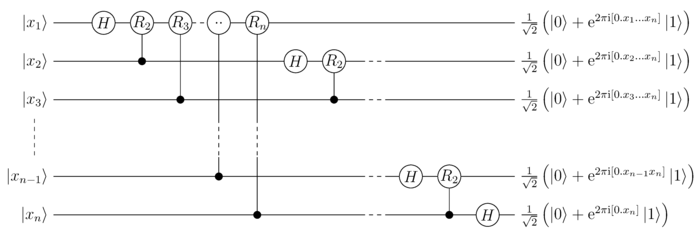

In [12]:
''' Function to create QFT for a given circuit and its up_reg (num = n) , also has a 
swap-condition to increase functionality '''
def create_QFT(circuit , up_reg , n , with_swap):
    i = n-1
    # pre swap , we do the operations
    while i >= 0:
        circuit.h(up_reg[i])
        j = i-1
        # now we apply the controlled phase gates R_k
        while j>=0:
            # applying phase gate to up_reg[j], controlled by up_reg[i]
            if (np.pi)/(pow(2,(i-j))) > 0 :
                circuit.cp((np.pi)/(pow(2,(i-j))) , up_reg[i] , up_reg[j])
            j-=1
        i-=1
    # this is the end of the qft thing usually (with_swap = 0 usually)
        ''' doing the swaps (optional because in places like mod multiplication the goal
        isnt to get QFT but to rather add/multiply for which swap is unnecessary so it jus
        contributes to inreasing gate count'''
    if with_swap == 1:
            i = 0
            while i < (n-1)/2:
                circuit.swap(up_reg[i] , up_reg[n-i-1])
                i+=1
        

## QFT_INV

In [13]:
def create_inverse_QFT(circuit,up_reg,n,with_swaps):
    # If specified, apply the Swaps at the beggining
    if with_swaps==1:
        i=0
        while i < ((n-1)/2):
            circuit.swap(up_reg[i], up_reg[n-1-i])
            i=i+1
    
    # just reversing the operations in QFT
    i=0
    while i<n:
        circuit.h(up_reg[i])
        if i != n-1:
            j=i+1
            y=i
            while y>=0:
                 if (np.pi)/(pow(2,(j-y))) > 0:
                    circuit.cp( - (np.pi)/(pow(2,(j-y))) , up_reg[j] , up_reg[y] )
                    y=y-1   
        i=i+1

# SETTING UP MODULAR ADDITION 

In [14]:
def c_cphase(circuit , angle , ctl1 , ctl2 , tgt):
    # applies doubly controlled phase gate
    circuit.cp(angle/2 , ctl1 , tgt)
    circuit.cx(ctl2,ctl1)
    circuit.cp(-angle/2 , ctl1 , tgt)
    circuit.cx(ctl2,ctl1)
    circuit.cp(angle/2 , ctl2 , tgt)
    

In [15]:
"""Function that calculates the array of angles to be used in the addition in Fourier Space"""
def getAngles(a,N): # note : N here is just the no. of qubits for adding a , not the N = pq
    s=bin(int(a))[2:].zfill(N) 
    angles=np.zeros([N])
    for i in range(0, N):
        for j in range(i,N):
            if s[j]=='1':
                angles[N-i-1]+=math.pow(2, -(j-i))
        angles[N-i-1]*=np.pi
    return angles

In [16]:
''' ckt to perform add by a in the fourier space
equivalent to subtracter if inv is set to !0 
q is array of qubits in the ckt '''
def phi_add(circuit , q , a , n , inv ): # n here is number of qubits more or less
    angle = getAngles(a,n)
    for i in range(n):
        if inv == 0:
            circuit.p(angle[i],q[i])
        else:
            circuit.p(-angle[i],q[i])

In [17]:
"""Single controlled version of the phiADD circuit"""
def cphiADD(circuit,q,ctl,a,n,inv): # n here is number of qubits
    angle=getAngles(a,n)
    for i in range(0,n):
        if inv==0:
            circuit.cp(angle[i],ctl,q[i])
        else:
            circuit.cp(-angle[i],ctl,q[i])

In [18]:
# doubly controlled addition by a in the fourier space
def c_cphiadd(circuit,q,ctl1,ctl2,a,N,inv):
    angle = getAngles(a,N)
    for i in range(N):
        if inv == 0:
            c_cphase(circuit , angle[i] , ctl1,ctl2,q[i])
        else:
            c_cphase(circuit , -angle[i] , ctl1,ctl2,q[i])

In [19]:
# doing doubly modular addition by a (mod N)
def c_cphiadd_modN(circuit , q, ctl1, ctl2 , aux , a, N,n):
    c_cphiadd(circuit,q,ctl1,ctl2,a,n,0) # add a
    phi_add(circuit,q,N,n,1) # subtract N
    create_inverse_QFT(circuit,q,n,0) # inv Qft to check msb for doing modular addn
    circuit.cx(q[n-1],aux) # checking if addition by a exceeds N
    create_QFT(circuit , q , n , 0) # recreating qft after check
    cphiADD(circuit,q,aux,N,n,0) # adding N back if a's addition didnt exceed N


    c_cphiadd(circuit,q,ctl1,ctl2,a,n,1) # subtracting a
    create_inverse_QFT(circuit,q,n,0) 
    circuit.x(q[n-1])
    circuit.cx(q[n-1],aux)
    circuit.x(q[n-1])
    create_QFT(circuit , q , n , 0) # recreating qft after check
    c_cphiadd(circuit,q,ctl1,ctl2,a,n,0)




In [20]:
# ckt to implement inv of doubly controlled modular addition (reverse each gate and order)
def c_cphiadd_modN_inv(circuit, q, ctl1, ctl2, aux, a, N, n):
    c_cphiadd(circuit, q, ctl1, ctl2, a, n, 1)
    create_inverse_QFT(circuit, q, n, 0)
    circuit.x(q[n-1])
    circuit.cx(q[n-1],aux)
    circuit.x(q[n-1])
    create_QFT(circuit, q, n, 0)
    c_cphiadd(circuit, q, ctl1, ctl2, a, n, 0)
    cphiADD(circuit, q, aux, N, n, 1)
    create_inverse_QFT(circuit, q, n, 0)
    circuit.cx(q[n-1], aux)
    create_QFT(circuit, q, n, 0)
    phi_add(circuit, q, N, n, 0)
    c_cphiadd(circuit, q, ctl1, ctl2, a, n, 1)

In [21]:
def egcd(a, b):
    if a == 0:
        return (b, 0, 1)
    else:
        g, y, x = egcd(b % a, a)
        return (g, x - (b // a) * y, y)

In [22]:
def modinv(a, m):
    g, x, y = egcd(a, m)
    if g != 1:
        raise Exception('modular inverse does not exist')
    else:
        return x % m

In [23]:
def c_mult_modN(circuit,ctl1,q,aux,a,N,n): # controlled mult. by a (mod N)
    # aux is an array of n+1 qubits set to |0>
    create_QFT(circuit,aux,n+1,0)
    for i in range(n):
        c_cphiadd_modN(circuit,aux,q[i],ctl1,aux[n+1],(2**i)*a%N,N,n+1)
    create_inverse_QFT(circuit, aux, n+1, 0)
    for i in range(0,n): # swap contents 
        circuit.cswap(ctl1,q[i],aux[i])
    a_inv = modinv(a,N)
    # now multilpying contents of 2nd reg ( now in state |q> ) with a-1 mod N * aqmodN essentially
    create_QFT(circuit,aux,n+1,0)
    for i in range(n-1,-1,-1):
        c_cphiadd_modN_inv(circuit,aux,q[i],ctl1,aux[n+1],math.pow(2,i)*a_inv%N,N,n+1)
    create_inverse_QFT(circuit, aux, n+1, 0)
    


In [24]:
def get_coprime(N):
    return random.randint(2,N-2)

In [25]:
def Shors_Algorithm(N,a):
    n = math.ceil(math.log(N,2)) # number of bits for N
    # this algo uses 4n+2 qubits
    aux  = QuantumRegister(n+2) # aux for addn / multiplication (mod N)
    up_reg = QuantumRegister(2*n) # for QFT ( t = 2n qubits )
    down_reg = QuantumRegister(n) # register where mod multiplication is applied
    up_classic = ClassicalRegister(2*n) # for storing results

    """ Create Quantum Circuit """
    circuit = QuantumCircuit(down_reg , up_reg , aux, up_classic)

    # create superposn + |1> state in down registers
    circuit.h(up_reg)
    circuit.x(down_reg[0])

    for i in range(2*n):
        c_mult_modN(circuit,up_reg[i],down_reg,aux,int(pow(a,pow(2,i))),N,n) # controlled mult. by a^(2^i) (mod N)


    # applying QFT_inv
    create_inverse_QFT(circuit,up_reg,2*n,1)
    
    # measure top qubits
    circuit.measure(up_reg,up_classic)

    #return circuit
    return circuit

In [26]:
def get_answer(counts,N,n):
 t = 2*n
    # this output is essentially (s/r)/2*t (t = 2n) - s is the random eigenvector number we got
# as our input is |1> = sum of all eigenstates from s = 0 to r-1
#converting to s/r
 rows, measured_phases = [], []
 for output in counts:
    decimal = int(output, 2)  # Convert (base 2) string to decimal
    phase = decimal/(2**t)  # Find corresponding eigenvalue
    measured_phases.append(phase)
    # Add these values to the rows in our table:
    rows.append([f"{output}(bin) = {decimal:>3}(dec)",
                 f"{decimal}/{2**t} = {phase:.2f}"])
# Print the rows in a table
 headers=["Register Output", "Phase"]
 df = pd.DataFrame(rows, columns=headers)
 print(df)
 # continued fractions to determine r
 rows = []
 for phase in measured_phases:
    frac = Fraction(phase).limit_denominator(N) #gets the c.f expansion
    rows.append([phase,
                 f"{frac.numerator}/{frac.denominator}",
                 frac.denominator])
#print
 headers=["Phase", "Fraction", "Guess for r"]
 df = pd.DataFrame(rows,columns = headers)
 print(df) 
 return frac.denominator   
    

In [31]:
''' main program '''
N = 21 #int(input("Enter number to factorize : "))
a = 2
gcd = math.gcd(a,N)
if gcd!= 1:
    print("Factors are : " , gcd , N/gcd)
else:
    circuit = Shors_Algorithm(N,a)
    # draw the circuit
    #circuit.draw(output = 'mpl') # draw ckt (fold = 1 makes it more like vertical)
    #plt.show()
    aer_sim = AerSimulator()
    t_qc = transpile(circuit, aer_sim)
    counts = aer_sim.run(t_qc,shots = 1).result().get_counts()
    r_guess = get_answer(counts,N,math.ceil(math.log(N, 2)))
    if r_guess%2==0:
      period = int(r_guess / 2)
      print("FACTORS CANDIDATES ARE : ",math.gcd(N, (a ** period - 1)),math.gcd(N, (a ** period + 1)))
    else:
      print("found period isn't divisible by 2, try again")
    
    

              Register Output            Phase
0  0010101011(bin) = 171(dec)  171/1024 = 0.17
      Phase Fraction  Guess for r
0  0.166992      1/6            6
FACTORS CANDIDATES ARE :  7 3
